In [118]:
import whatsapptojson
import re
import seaborn
import matplotlib.pyplot as plt
import datetime
import pandas as pd

In [101]:
#Put in the name of the file with your chat data
chatname=''

In [102]:
#Depending on the country you are from it could be that the date is saved differently. 
#Have a look at the txt. file you exported from WhatsApp and adapt it if necessary 
def startsWithDate(s):
    pattern = '^([0-2][0-9]|(3)[0-1])(\.)(((0)[0-9])|((1)[0-2]))(\.)(\d{2}|\d{4}), ([0-9][0-9]):([0-9][0-9]) -'
    result = re.match(pattern, s)
    if result:
        return True
    return False

In [103]:
def startsWithAuthor(s):
    patterns = [
        '([\w]+):',                        # First Name
        '([\w]+[\s]+[\w]+):',              # First Name + Last Name
        '([\w]+[\s]+[\w]+[\s]+[\w]+):',    # First Name + Middle Name + Last Name
        '([+]\d{2} \d{5} \d{5}):',         # Mobile Number (India)
        '([+]\d{2} \d{3} \d{3} \d{4}):',   # Mobile Number (US)
        '([+]\d{2} \d{4} \d{7})'           # Mobile Number (Europe)
    ]
    pattern = '^' + '|'.join(patterns)
    result = re.match(pattern, s)
    if result:
        return True
    return False


In [104]:
def getDataPoint(line):
    # line = 18/06/17, 22:47 - Loki: Why do you have 2 numbers, Banner?
    
    splitLine = line.split(' - ') # splitLine = ['18/06/17, 22:47', 'Loki: Why do you have 2 numbers, Banner?']
    
    dateTime = splitLine[0] # dateTime = '18/06/17, 22:47'
    
    date, time = dateTime.split(', ') # date = '18/06/17'; time = '22:47'
    
    message = ' '.join(splitLine[1:]) # message = 'Loki: Why do you have 2 numbers, Banner?'
    
    if startsWithAuthor(message): # True
        splitMessage = message.split(': ') # splitMessage = ['Loki', 'Why do you have 2 numbers, Banner?']
        author = splitMessage[0] # author = 'Loki'
        message = ' '.join(splitMessage[1:]) # message = 'Why do you have 2 numbers, Banner?'
    else:
        author = None
    return date, time, author, message

In [105]:
parsedData = [] # List to keep track of data so it can be used by a Pandas dataframe
conversationPath = chatname
with open(conversationPath, encoding="utf-8") as fp:
    fp.readline() # Skipping first line of the file (usually contains information about end-to-end encryption)
        
    messageBuffer = [] # Buffer to capture intermediate output for multi-line messages
    date, time, author = None, None, None # Intermediate variables to keep track of the current message being processed
    
    while True:
        line = fp.readline() 
        if not line: # Stop reading further if end of file has been reached
            break
        line = line.strip() # Guarding against erroneous leading and trailing whitespaces
        if startsWithDate(line): # If a line starts with a Date Time pattern, then this indicates the beginning of a new message
            if len(messageBuffer) > 0: # Check if the message buffer contains characters from previous iterations
                parsedData.append([date, time, author, ' '.join(messageBuffer)]) # Save the tokens from the previous message in parsedData
            messageBuffer.clear() # Clear the message buffer so that it can be used for the next message
            date, time, author, message = getDataPoint(line) # Identify and extract tokens from the line
            messageBuffer.append(message) # Append message to buffer
        else:
            messageBuffer.append(line) # If a line doesn't start with a Date Time pattern, then it is part of a multi-line message. So, just append to buffer


In [106]:
df = pd.DataFrame(parsedData, columns=['Date', 'Time', 'Author', 'Message'])
df.head(10)


      

,Date,Time,Author,Message
0,23.03.15,19:00,None,‎Johanna Schleder hat die Gruppe „Family🙈❤“ er...
1,05.09.16,21:00,None,‎Johanna Schleder hat dich hinzugefügt.
2,05.09.16,20:29,Heinrich Gotthard,<Medien ausgeschlossen>
3,05.09.16,21:41,Mama,😄
4,05.09.16,22:49,Johanna Schleder,"Schau mal, was Susi an die Akk-MM-Gruppe gesch..."
5,05.09.16,22:49,Johanna Schleder,Also ich bin mit der Zimmer Aufteilung sehr zu...
6,05.09.16,22:51,Mama,Hab' s gesehen 😂👍🏻
7,05.09.16,22:55,Johanna Schleder,"Wie schade, dass Oma kein WhatsApp hat. Das is..."
8,05.09.16,22:55,Mama,Stimmt 😉
9,21.09.16,22:05,Katharina Schleder,<Medien ausgeschlossen>


**Data Exploration**

In [107]:
df.describe()

,Date,Time,Author,Message
count,3924,3924,3908,3924
unique,571,993,11,2474
top,25.07.19,20:06,Mama,<Medien ausgeschlossen>
freq,53,16,1042,874


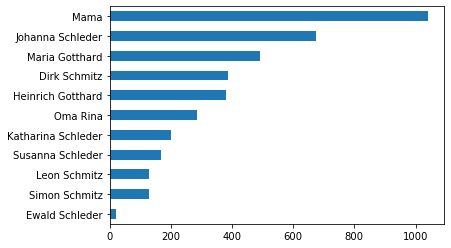

In [112]:
author_value_counts = df['Author'].value_counts() # Number of messages per author
top_7_author_value_counts = author_value_counts.head(15) # Number of messages per author for the top 10 most active authors
top_7_author_value_counts=top_7_author_value_counts.sort_values(ascending=True)
top_7_author_value_counts.plot.barh() # Plot a bar chart using pandas built-in plotting apis

In [109]:

null_authors_df = df[df['Author'].isnull()]
null_authors_df.head()


,Date,Time,Author,Message
0,23.03.15,19:00,None,‎Johanna Schleder hat die Gruppe „Family🙈❤“ er...
1,05.09.16,21:00,None,‎Johanna Schleder hat dich hinzugefügt.
327,06.01.17,00:27,None,‎Johanna Schleder hat +49 1512 2096092 entfernt.
477,02.03.17,19:12,None,‎Johanna Schleder hat Ewald Schleder hinzugefügt.
551,22.03.17,16:35,None,‎Johanna Schleder hat Maria Gotthard hinzugefügt.


        Date   Time              Author                  Message
2   05.09.16  20:29   Heinrich Gotthard  <Medien ausgeschlossen>
9   21.09.16  22:05  Katharina Schleder  <Medien ausgeschlossen>
17  22.09.16  20:36       Simon Schmitz  <Medien ausgeschlossen>
21  01.10.16  21:17    Susanna Schleder  <Medien ausgeschlossen>
22  01.10.16  22:20  Katharina Schleder  <Medien ausgeschlossen>


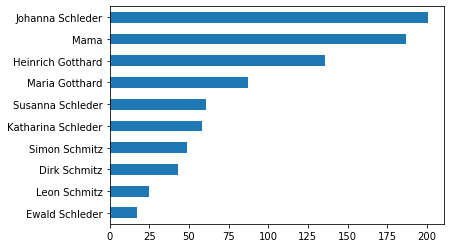

In [113]:
#Adapt this to your language. Because my WhatsApp is set to German the file contains '<Medien ausgeschlossen>' as a placeholder
#for media files which weren't included in the export. Have a look to your file to see what the equivalent in your language is
media_messages_df = df[df['Message'] == '<Medien ausgeschlossen>']
print(media_messages_df.head())

author_media_messages_value_counts = media_messages_df['Author'].value_counts()
top_10_author_media_messages_value_counts = author_media_messages_value_counts.head(10)
top_10_author_media_messages_value_counts=top_10_author_media_messages_value_counts.sort_values(ascending=True)
top_10_author_media_messages_value_counts.plot.barh()

**Data Cleaning**


In [92]:
#Added the axis argument because the default argument for drop is to drop columns not rows

messages_df = df.drop(null_authors_df.index,axis=0) # Drops all rows of the data frame containing messages from null authors
messages_df = messages_df.drop(media_messages_df.index) # Drops all rows of the data frame containing media messages
messages_df.head()

,Date,Time,Author,Message
2,01.09.16,15:11,Dreni Mehani,Jawoll Simon wieder back
3,01.09.16,16:14,Dreni Mehani,Begeisterung hält sich in Grenzen
4,01.09.16,16:14,Dreni Mehani,Kopf hoch simon
5,01.09.16,16:30,Simon Schmitz,Haha komm ich mit klar trotzdem danke meh 😄😘
6,01.09.16,16:31,Dreni Mehani,Wie war es denn


**Data Augmentation**

In [93]:

messages_df['Letter_Count'] = messages_df['Message'].apply(lambda s : len(s))
messages_df['Word_Count'] = messages_df['Message'].apply(lambda s : len(s.split(' ')))


In [94]:

discrete_columns = ['Date', 'Time', 'Author', 'Message']
messages_df[discrete_columns].describe()

continuous_columns = ['Letter_Count', 'Word_Count']
messages_df[continuous_columns].describe()

,Letter_Count,Word_Count
count,15059.000000,15059.000000
mean,32.012484,6.001859
std,34.834533,6.086910
min,1.000000,1.000000
25%,11.000000,2.000000
50%,23.000000,4.000000
75%,41.000000,8.000000
max,778.000000,124.000000


In [95]:
messages_df['Letter_Count'].sum(), messages_df['Word_Count'].sum()

(482076, 90382)

This next step transforms the Date column to a date object to allow further analysis with it



In [96]:
messages_df['Date'] = messages_df['Date'].apply(pd.to_datetime)


In [97]:
messages_df.head(10)

,Date,Time,Author,Message,Letter_Count,Word_Count
2,2016-01-09,15:11,Dreni Mehani,Jawoll Simon wieder back,24,4
3,2016-01-09,16:14,Dreni Mehani,Begeisterung hält sich in Grenzen,33,5
4,2016-01-09,16:14,Dreni Mehani,Kopf hoch simon,15,3
5,2016-01-09,16:30,Simon Schmitz,Haha komm ich mit klar trotzdem danke meh 😄😘,44,9
6,2016-01-09,16:31,Dreni Mehani,Wie war es denn,15,4
7,2016-01-09,16:31,Dreni Mehani,Paar korrekte storys,20,3
8,2016-01-09,16:43,Simon Schmitz,Aus Amerika ?,13,3
9,2016-01-09,16:45,Dreni Mehani,Ne orenhofen,12,2
10,2016-01-09,16:45,Dreni Mehani,Ja sicha junge! 😂😂❤,19,4
11,2016-01-09,16:47,Simon Schmitz,Naja abgesehen von dem Einbruch wars ziemlich ...,53,9


Words used by the different people in the chat

Text(0, 0.5, 'Authors')

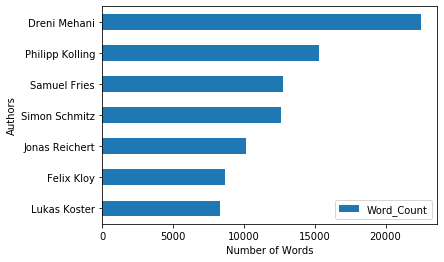

In [120]:
total_word_count_grouped_by_author = messages_df[['Author', 'Word_Count']].groupby('Author').sum()
sorted_total_word_count_grouped_by_author = total_word_count_grouped_by_author.sort_values('Word_Count', ascending=True)
top_10_sorted_total_word_count_grouped_by_author = sorted_total_word_count_grouped_by_author.head(10)
top_10_sorted_total_word_count_grouped_by_author.plot.barh()
plt.xlabel('Number of Words')
plt.ylabel('Authors')

Most common number of words

Text(0, 0.5, 'Frequency')

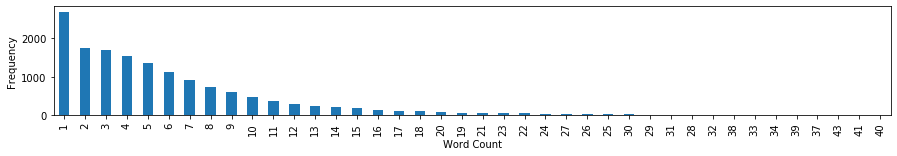

In [121]:

plt.figure(figsize=(15, 2)) # To ensure that the bar plot fits in the output cell of a Jupyter notebook
word_count_value_counts = messages_df['Word_Count'].value_counts()
top_40_word_count_value_counts = word_count_value_counts.head(40)
top_40_word_count_value_counts.plot.bar()
plt.xlabel('Word Count')
plt.ylabel('Frequency')

Day on which the most messages where sent

Text(0, 0.5, 'Date')

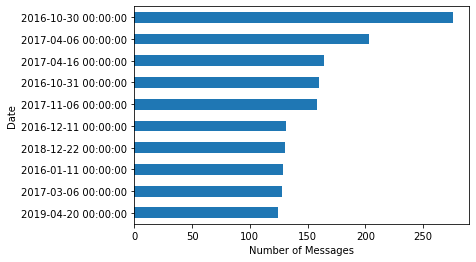

In [135]:
#Adding a sort_values reorders the bar chart from highest to lowest
messages_df['Date'].value_counts().head(10).sort_values().plot.barh() # Top 10 Dates on which the most number of messages were sent
plt.xlabel('Number of Messages')
plt.ylabel('Date')

Time of the day where most messages were sent

Text(0, 0.5, 'Time')

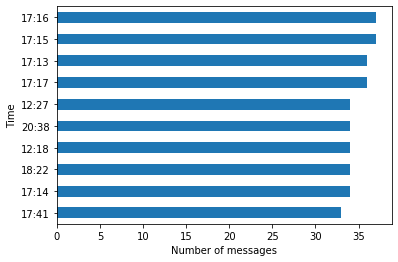

In [140]:
messages_df['Time'].value_counts().head(10).sort_values().plot.barh() # Top 10 Times of the day at which the most number of messages were sent
plt.xlabel('Number of messages')
plt.ylabel('Time')

Text(0, 0.5, 'Hour of Day')

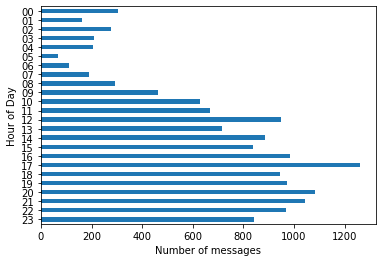

In [143]:
messages_df['Hour'] = messages_df['Time'].apply(lambda x : x.split(':')[0]) # The first token of a value in the Time Column contains the hour (Eg., "20" in "20:15")
messages_df['Hour'].value_counts().head(24).sort_index(ascending=False).plot.barh() # Top 10 Hours of the day during which the most number of messages were sent
plt.xlabel('Number of messages')
plt.ylabel('Hour of Day')

In [152]:
messages_df.head()

,Date,Time,Author,Message,Letter_Count,Word_Count,Hour
2,2016-01-09,15:11,Dreni Mehani,Jawoll Simon wieder back,24,4,15
3,2016-01-09,16:14,Dreni Mehani,Begeisterung hält sich in Grenzen,33,5,16
4,2016-01-09,16:14,Dreni Mehani,Kopf hoch simon,15,3,16
5,2016-01-09,16:30,Simon Schmitz,Haha komm ich mit klar trotzdem danke meh 😄😘,44,9,16
6,2016-01-09,16:31,Dreni Mehani,Wie war es denn,15,4,16


In [172]:
#Print messages that were sent at 5 in the morning. At least in my groups this is funny stuff
mask=messages_df['Hour']== '05'
Morgen_Gespräche = messages_df[mask]['Message']

print(Morgen_Gespräche.tail(25))

8107                                       Kommt Garderobe
9842                                                  Hhhh
9843                                                  Ahhh
9844                                                   Nix
9845                                      Bin jetzt dahoam
9853                                      Reichert 0 wir 1
9854     Noch einmal und ich mach kein fahrer mehr für ...
9855                                                     😎
9861                                     Shoots been fired
9862                                                     🔥
11656                                                 gibt
11657                                             Mir en a
11658                                               Ein am
11659                                            Und ein l
11660                                                    K
12670                                    Ganz ehrlich näää
12672                      Was machst du bei Eva im Bett